# Visual Document NER v2 with relation extraction

In [1]:
secret = ""
license = ""
version = secret.split("-")[0]
spark_ocr_jar_path = "../../target/scala-2.11/"
AWS_ACCESS_KEY_ID = ""
AWS_SECRET_ACCESS_KEY = ""

import os
os.environ['JSL_OCR_LICENSE'] = license
os.environ["AWS_ACCESS_KEY_ID"] = AWS_ACCESS_KEY_ID
os.environ["AWS_SECRET_ACCESS_KEY"] = AWS_SECRET_ACCESS_KEY

In [3]:
#%pip install spark-ocr==$version+spark30 --extra-index-url=https://pypi.johnsnowlabs.com/$secret --upgrade

In [4]:
#%pip install ../../python/dist/spark-ocr-3.9.0+spark30.tar.gz

In [5]:
import pyspark
import sparkocr
import json
import os

from pyspark.sql import SparkSession
from pyspark.ml import PipelineModel
import pyspark.sql.functions as f

from sparkocr.transformers import *
from sparkocr.utils import display_images
from sparkocr.enums import *

### Initialize Spark session

In [6]:
from sparkocr import start
from pyspark import SparkConf

spark = start(jar_path = spark_ocr_jar_path)
spark

Spark version: 3.0.2
Spark NLP version: 3.3.4
Spark OCR version: 3.10.0



## Load test images

In [7]:
import pkg_resources
test_image_path = pkg_resources.resource_filename('sparkocr', 'resources/ocr/forms/form1.jpg')
bin_df = spark.read.format("binaryFile").load(test_image_path)
bin_df.show()

+--------------------+-------------------+------+--------------------+
|                path|   modificationTime|length|             content|
+--------------------+-------------------+------+--------------------+
|file:/home/alexan...|2022-01-13 11:59:17|421333|[FF D8 FF E0 00 1...|
+--------------------+-------------------+------+--------------------+



## Display images


    Image #0:
    Origin: file:/home/alexander_jsl/Workspace/spark-ocr/python/sparkocr/resources/ocr/forms/form1.jpg
    Resolution: 150 dpi
    Width: 1240 px
    Height: 1755 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


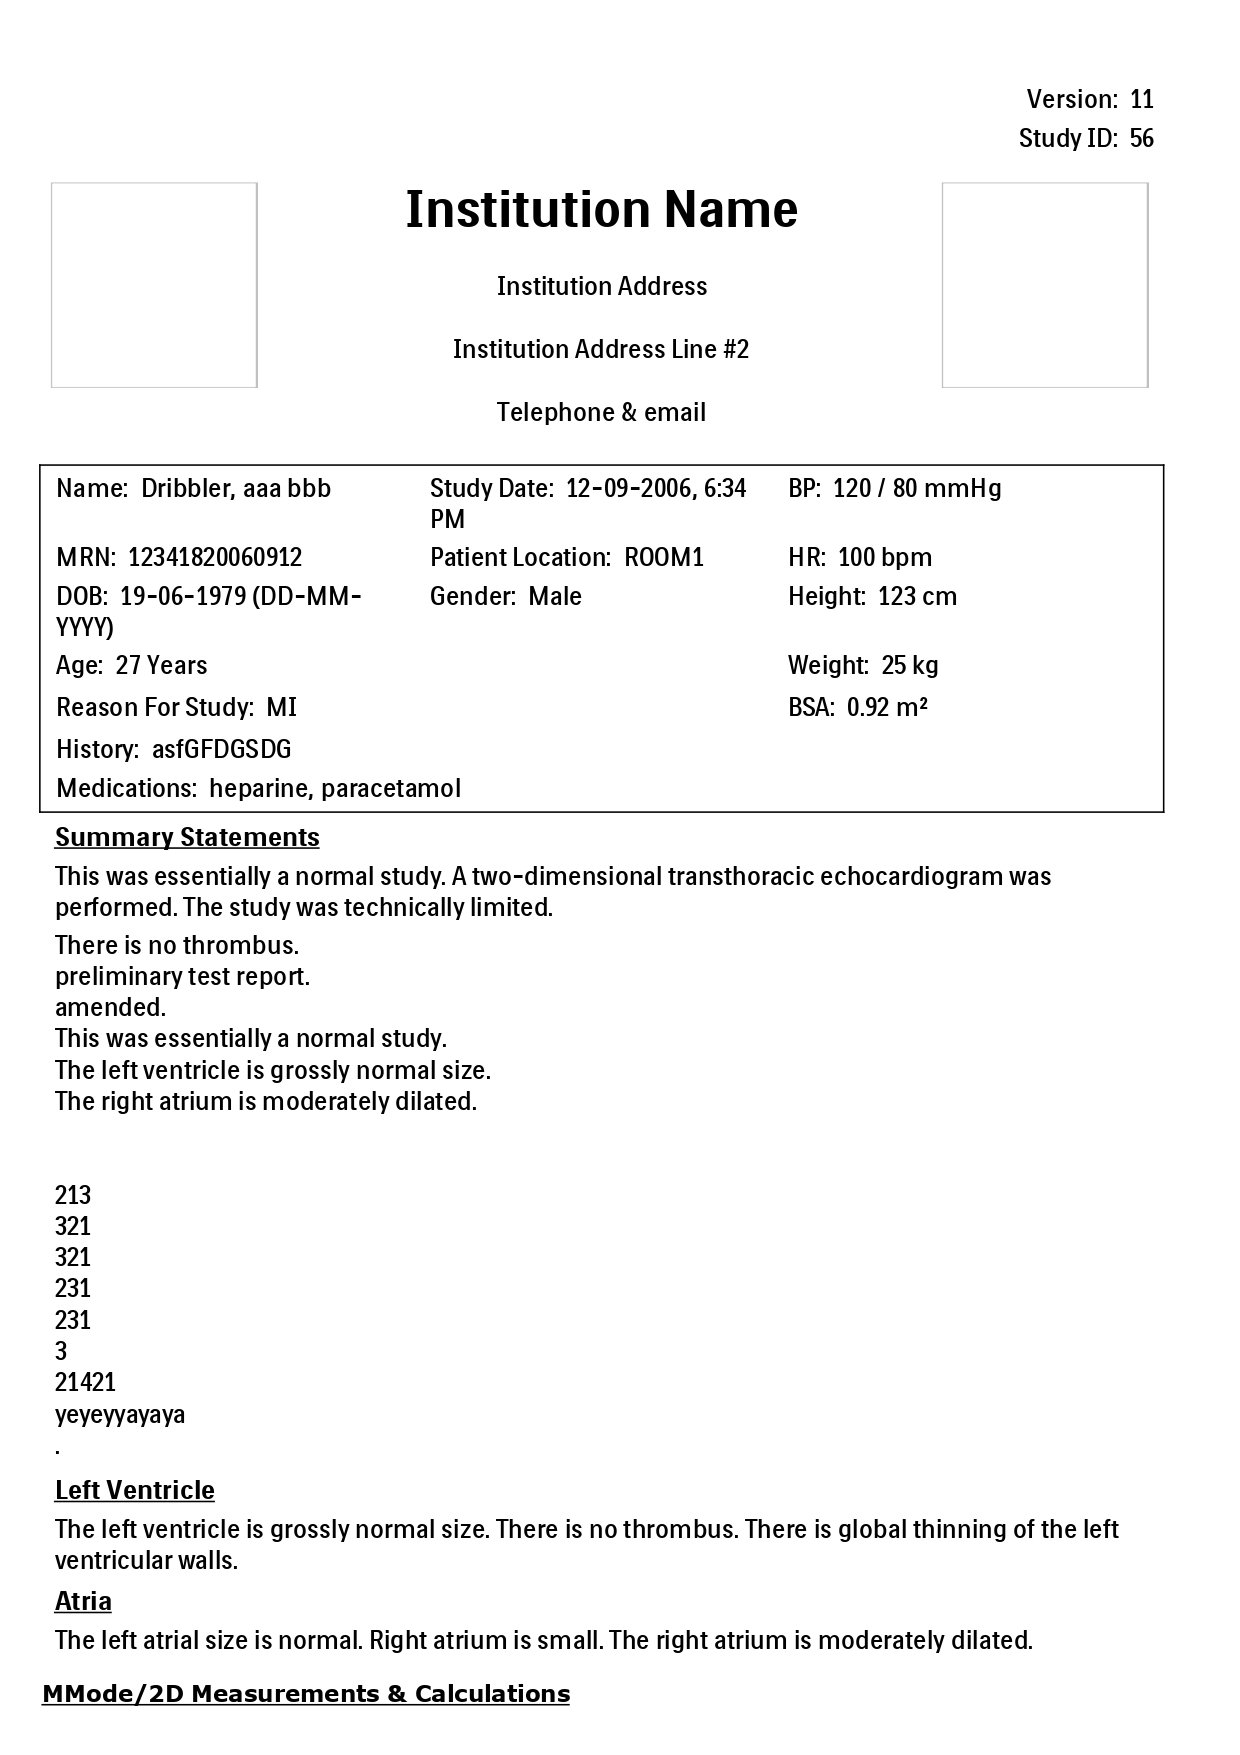

In [8]:
image_df = BinaryToImage().transform(bin_df)
display_images(image_df)

### Define pipeline

In [9]:
binary_to_image = BinaryToImage()\
    .setOutputCol("image") \
    .setImageType(ImageType.TYPE_3BYTE_BGR)

img_to_hocr = ImageToHocr()\
    .setInputCol("image")\
    .setOutputCol("hocr")\
    .setIgnoreResolution(False)\
    .setOcrParams(["preserve_interword_spaces=0"])

tokenizer = HocrTokenizer()\
    .setInputCol("hocr")\
    .setOutputCol("token")

doc_ner = VisualDocumentNerV2()\
    .pretrained("layoutlmv2_key_value_pairs", "en", "clinical/ocr")\
    .setInputCols(["token", "image"])\
    .setOutputCol("entities")

rel_extractor = FormRelationExtractor()\
    .setInputCol("entities")\
    .setOutputCol("relations_")

draw = ImageDrawAnnotations() \
    .setInputCol("image") \
    .setInputChunksCol("relations_") \
    .setOutputCol("image_with_annotations") \
    .setFontSize(10) \
    .setLineWidth(4)\
    .setRectColor(Color.red)

# OCR pipeline
pipeline = PipelineModel(stages=[
    binary_to_image,
    img_to_hocr,
    tokenizer,
    doc_ner,
    rel_extractor,
    draw,
])

## Call pipeline

In [10]:
results = pipeline.transform(bin_df).cache()

## Show results

In [11]:
## since pyspark2.3 doesn't have element_at, 'getItem' is involked
path_array = f.split(results['path'], '/')

# from pyspark2.4
# results.withColumn("filename", f.element_at(f.split("path", "/"), -1)) \

results.withColumn('filename', path_array.getItem(f.size(path_array)- 1)) \
    .withColumn("exploded_entities", f.explode("entities")) \
    .select("filename", "exploded_entities") \
    .show(truncate=False)

+---------+-------------------------------------------------------------------------------------------------------------------------+
|filename |exploded_entities                                                                                                        |
+---------+-------------------------------------------------------------------------------------------------------------------------+
|form1.jpg|[entity, 12, 16, b-question, [x -> 1020, y -> 128, height -> 23, confidence -> 95, word -> Study, width -> 61], []]      |
|form1.jpg|[entity, 18, 19, i-question, [x -> 1088, y -> 128, height -> 19, confidence -> 96, word -> ID:, width -> 29], []]        |
|form1.jpg|[entity, 25, 35, b-header, [x -> 407, y -> 190, height -> 37, confidence -> 96, word -> Institution, width -> 241], []]  |
|form1.jpg|[entity, 37, 40, i-header, [x -> 667, y -> 190, height -> 37, confidence -> 96, word -> Name, width -> 130], []]         |
|form1.jpg|[entity, 112, 115, b-question, [x -> 58, y -> 478, 

In [12]:
## since pyspark2.3 doesn't have element_at, 'getItem' is involked
path_array = f.split(results['path'], '/')

# from pyspark2.4
# results.withColumn("filename", f.element_at(f.split("path", "/"), -1)) \

results.withColumn('filename', path_array.getItem(f.size(path_array)- 1)) \
    .withColumn("exploded_relations", f.explode("relations_")) \
    .select("filename", "exploded_relations") \
    .show(truncate=False)
            

+---------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|filename |exploded_relations                                                                                                                                                                                                                                                                                                               |
+---------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


    Image #0:
    Origin: file:/home/alexander_jsl/Workspace/spark-ocr/python/sparkocr/resources/ocr/forms/form1.jpg
    Resolution: 0 dpi
    Width: 1240 px
    Height: 1755 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


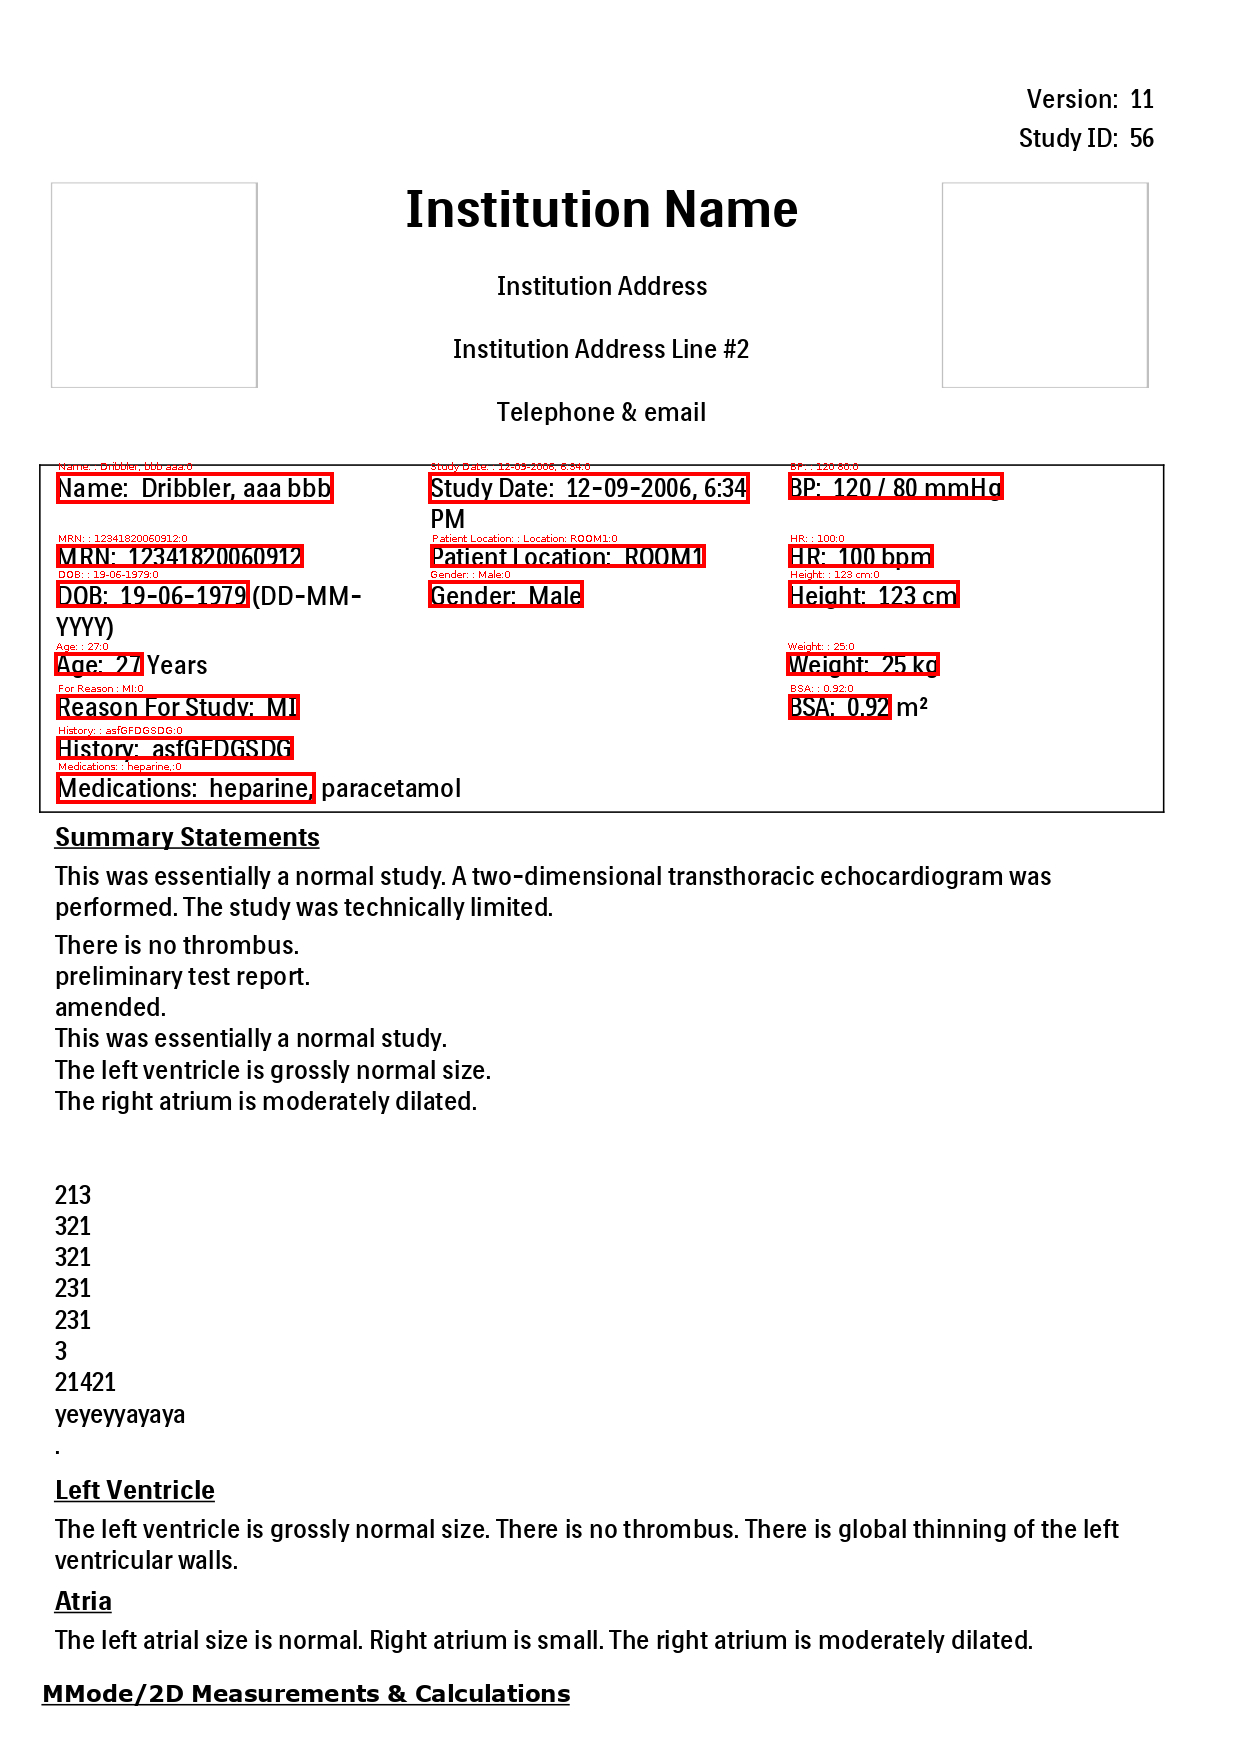

In [13]:
display_images(results, "image_with_annotations", width=1000)